In [1]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import librosa
from IPython import display


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten
# import tensorflow_io as tfio

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cat_file_path = "/content/drive/MyDrive/ML_GaganSir/ML_Project/datasets/Cats"
dog_file_path = "/content/drive/MyDrive/ML_GaganSir/ML_Project/datasets/Dogs"

In [4]:
# def load_audio_file(file_path):
#     wave, sr = librosa.load(file_path, sr=None)
#     return wave

In [5]:
def load_audio_file(file_path):
    if not isinstance(file_path, str):
        file_path = file_path.numpy().decode('utf-8')  # Convert TensorFlow tensor to string
    wave,_= librosa.load(file_path, sr=None)
    return wave

In [6]:
def load_audio_file(file_path):
    def load_file(file_path):
        file_path_str = file_path.numpy().decode('utf-8')
        wav, _ = librosa.load(file_path_str, sr=None)
        return wav

    wav = tf.py_function(load_file, [file_path], tf.float32)
    return wav

In [7]:
cat_wave = load_audio_file("/content/drive/MyDrive/ML_GaganSir/ML_Project/datasets/Cats/1-34094-A-5.wav")
dog_wave =  load_audio_file("/content/drive/MyDrive/ML_GaganSir/ML_Project/datasets/Dogs/1-110389-A-0.wav")

In [8]:
display.Audio(cat_wave, rate=16000)

In [9]:
display.Audio(dog_wave, rate=16000)

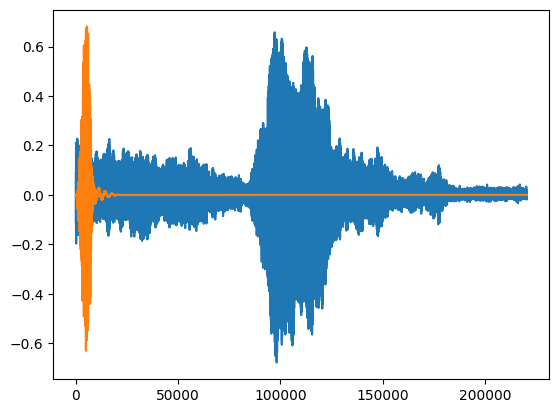

In [10]:
plt.plot(cat_wave)
plt.plot(dog_wave)
plt.show()

In [11]:
# Create the file pattern to match all WAV files
cat_files = os.path.join(cat_file_path, '*.wav')
cat_dataset = tf.data.Dataset.list_files(cat_files)

In [12]:
cat_dataset.as_numpy_iterator().next()

b'/content/drive/MyDrive/ML_GaganSir/ML_Project/datasets/Cats/1-79113-A-5.wav'

In [13]:
# Create the file pattern to match all WAV files
dog_files = os.path.join(dog_file_path, '*.wav')
dog_dataset = tf.data.Dataset.list_files(dog_files)

In [14]:
len(dog_dataset)

40

In [15]:
len(cat_dataset)

40

In [16]:
cats = tf.data.Dataset.zip((cat_dataset, tf.data.Dataset.from_tensor_slices(tf.zeros(len(cat_dataset)))))
dogs = tf.data.Dataset.zip((dog_dataset, tf.data.Dataset.from_tensor_slices(tf.ones(len(dog_dataset)))))
data = cats.concatenate(dogs)

In [17]:
data.shuffle(1000).as_numpy_iterator().next()

(b'/content/drive/MyDrive/ML_GaganSir/ML_Project/datasets/Cats/2-69131-A-5.wav',
 0.0)

In [18]:
lengths = []
for files in sorted(os.listdir(cat_file_path)):
  wave = load_audio_file(os.path.join(cat_file_path, files))
  lengths.append(len(wave))

In [19]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=220500>

In [20]:
def plot_spectrogram(spectrogram):
    """
    Plot a spectrogram.

    Parameters:
    - spectrogram: The input spectrogram tensor with shape (time, frequency, channels).
    """
    # Set the figure size
    plt.figure(figsize=(15, 5))

    # Transpose the spectrogram if needed
    # This depends on the structure of your tensor
    transposed_spectrogram = tf.transpose(spectrogram, perm=[1, 0, 2])

    # Plot the spectrogram
    plt.imshow(transposed_spectrogram[:, :, 0], aspect='auto', origin='lower', cmap='viridis')

    # Add labels and show the plot
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.title('Spectrogram')
    plt.colorbar(format='%+2.0f dB')

    plt.show()

In [21]:
def create_spec(file_path,label):
  wav = load_audio_file(file_path)
  spectogram = tf.signal.stft(wav , frame_length = 320 ,  frame_step = 32)
  spectogram = tf.abs(spectogram)
  spectogram = tf.expand_dims(spectogram, axis=2)
  return spectogram , label

In [22]:
filepath , label = cats.shuffle(1000).as_numpy_iterator().next()

In [23]:
wave =load_audio_file(filepath)
display.Audio(wave, rate=16000)

In [24]:
spectogram , label = create_spec(filepath,label)

In [25]:
# plt.figure(figsize=(30,20))
# plt.imshow(tf.transpose(spectogram)[0])
# plt.show()

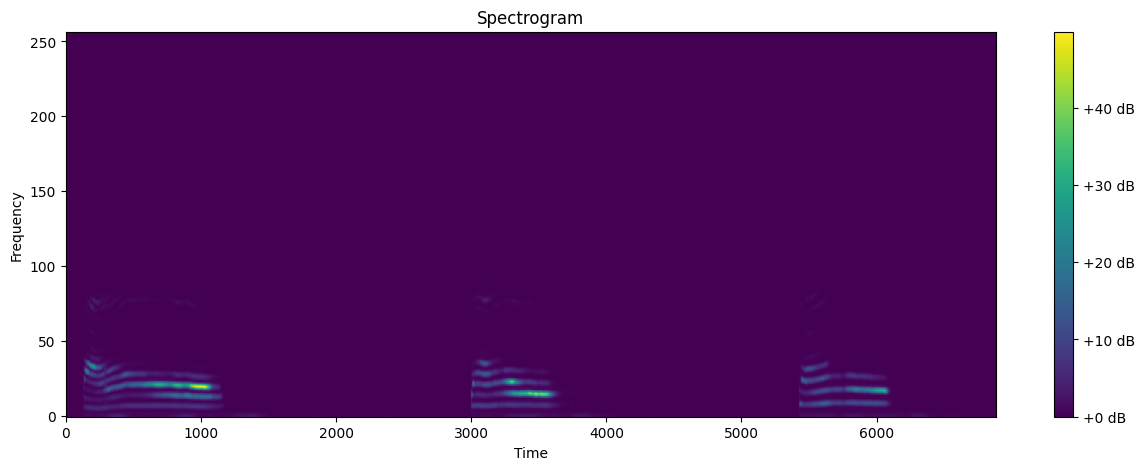

In [26]:
plot_spectrogram(spectogram)

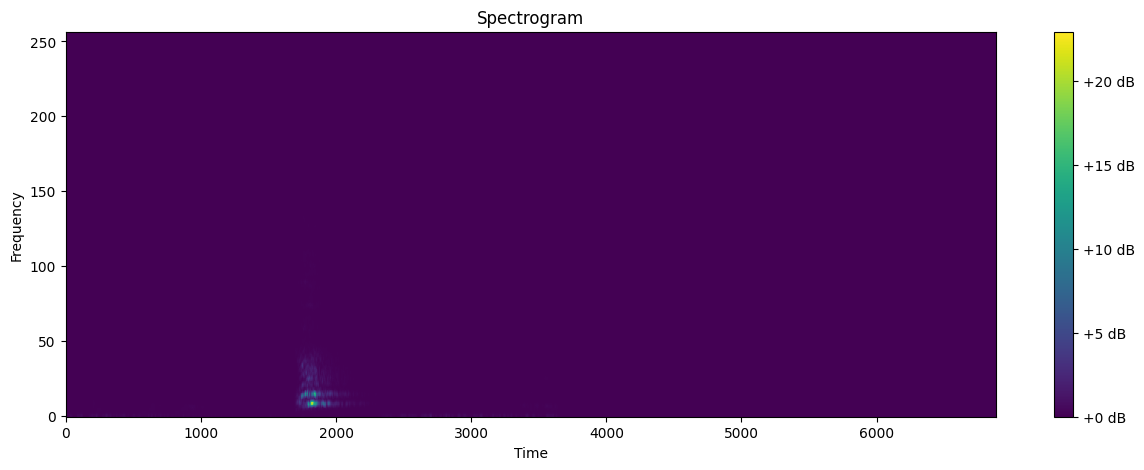

In [27]:
filepath , label = dogs.shuffle(1000).as_numpy_iterator().next()
spectogram , label = create_spec(filepath,label)
wave = load_audio_file(filepath)
plot_spectrogram(spectogram)
display.Audio(wave, rate=16000)

In [28]:
data = data.map(create_spec)
data =  data.cache()
data = data.shuffle(buffer_size = 1000)
data = data.batch(8)
data = data.prefetch(2)

In [29]:
train = data.take(7)
test = data.skip(7).take(10)

In [30]:
samples , labels = train.as_numpy_iterator().next()
samples.shape

(8, 6881, 257, 1)

In [31]:
labels

array([1., 0., 0., 1., 0., 1., 0., 0.], dtype=float32)

In [32]:
model = Sequential()
model.add(Conv2D(4, (3, 3), activation='relu', input_shape=(6881, 257, 1)))
model.add(Conv2D(4, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [33]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 6879, 255, 4)      40        
                                                                 
 conv2d_1 (Conv2D)           (None, 6877, 253, 4)      148       
                                                                 
 flatten (Flatten)           (None, 6959524)           0         
                                                                 
 dense (Dense)               (None, 16)                111352400 
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 111352605 (424.78 MB)
Trainable params: 111352605 (424.78 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
7/7 [==============================] - 14s 232ms/step - loss: 12.3065 - recall: 0.6538 - precision: 0.5862 - val_loss: 0.1161 - val_recall: 1.0000 - val_precision: 0.9412
Epoch 2/4
7/7 [==============================] - 1s 194ms/step - loss: 1.6864 - recall: 0.9643 - precision: 0.7714 - val_loss: 1.7185 - val_recall: 0.9333 - val_precision: 0.9333
Epoch 3/4
7/7 [==============================] - 1s 197ms/step - loss: 1.1450 - recall: 0.8846 - precision: 0.9200 - val_loss: 0.3313 - val_recall: 0.9167 - val_precision: 0.9167
Epoch 4/4
7/7 [==============================] - 1s 219ms/step - loss: 0.0616 - recall: 0.9600 - precision: 0.9600 - val_loss: 0.0436 - val_recall: 1.0000 - val_precision: 1.0000


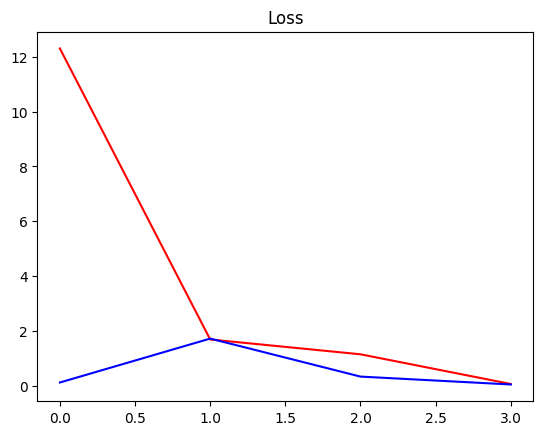

In [36]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

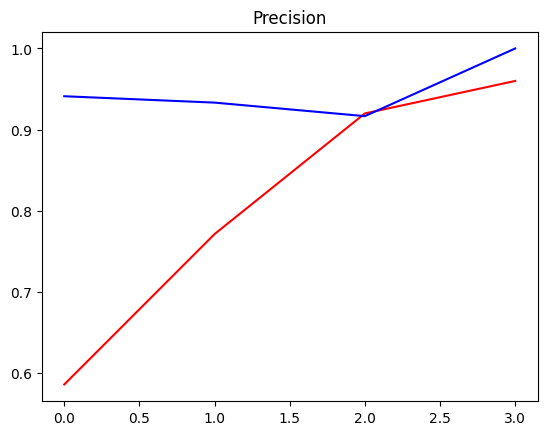

In [37]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

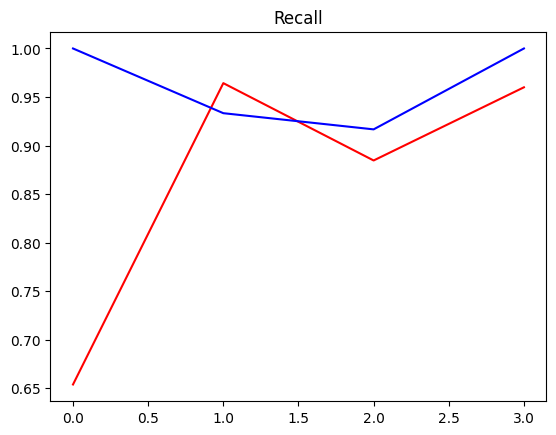

In [38]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

In [39]:
X_test ,  y_test = test.as_numpy_iterator().next()

In [40]:
y_test

array([1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)

In [41]:
X_test.shape

(8, 6881, 257, 1)

In [42]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 138ms/step


In [43]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [44]:
yhat

[1, 0, 0, 1, 1, 1, 1, 1]

In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [47]:
def calculate_classification_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return accuracy, precision, recall, f1

In [50]:
test_accuracy , precision , recall , f1 = calculate_classification_metrics(y_test, yhat)

In [51]:
print(f"Accuracy: {test_accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [45]:
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=6>

In [46]:
tf.math.reduce_sum(y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=6.0>